In [34]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel")
install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(32) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.495229 
Variance of RMST estimation of Control arm is: 2.732952e-05 
RMST of Experiment arm is: 0.6448322 
Variance of RMST estimation of Experiment arm is: 2.831875e-05

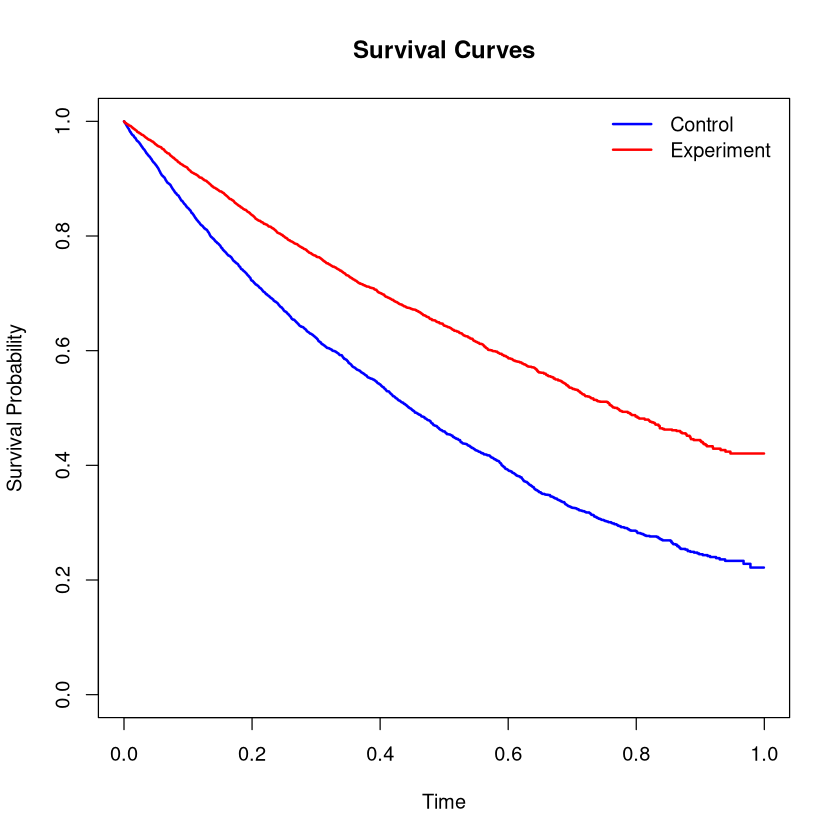

In [36]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.4923799 
Variance of RMST estimation of Control arm is: 1.212278e-05 
RMST of Experiment arm is: 0.6585054 
Variance of RMST estimation of Experiment arm is: 1.264252e-05

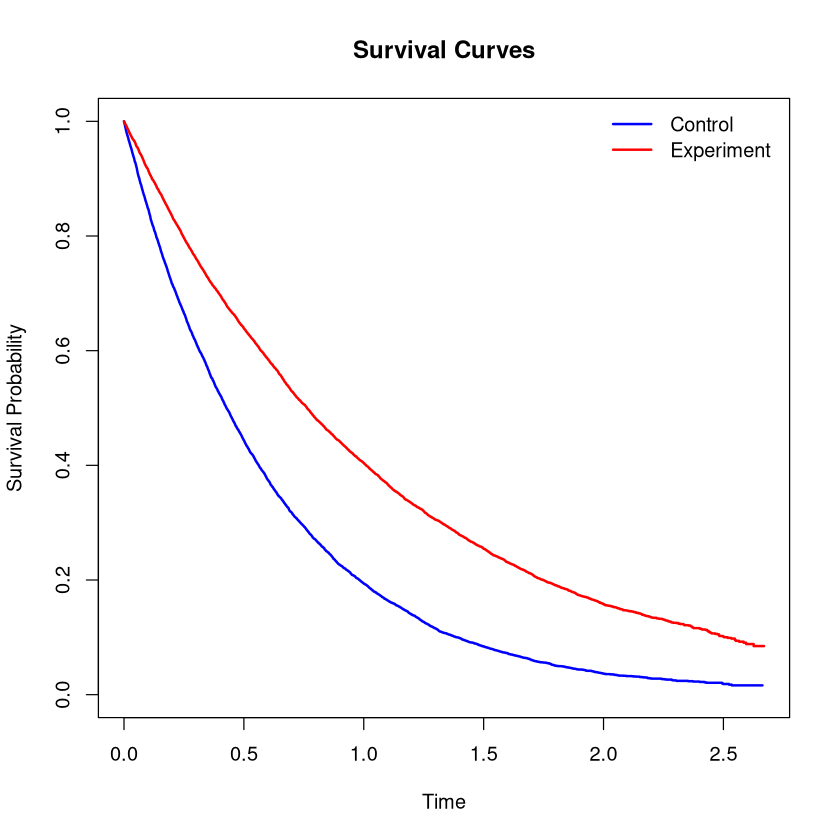

In [37]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$


In [ ]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 
### <span style="color:yellow"> I am trying to reproduce the result in Jung(2017) by grid searching 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year  
### <span style="color:yellow">The power is almost the same as 2 stages log rank design


In [ ]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.0999

[1] 0.9098

### Some experiments in Jung 2017 p650 table 1. Stop for futility only.
#### Optimal: $\lambda_2=0.9,\lambda_1 = \lambda_2*\Delta,n = 187, n_1 = 95, \alpha = 0.05, 1-\beta = 0.8$
#### $PET_0 = 0.556, PET_1 = 0.104$
#### Use my searching loop to find the critical value $m1, m2$

In [8]:
sim_size <- 10000 
acc_time <- 174 / 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / 60
set.seed(2024)
n <- ceiling(174/2)  #sample size per arm 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)                             

z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)

find_m_logrank(logrank_data = logrank_data, search_times = 1000, alpha = 0.05, sim_size = sim_size)


### Use the cut off point in Jung's paper
### <span style="color:yellow"> Same as the shown result in Jung's paper (yellow mark in the graph below)

In [ ]:
m1 <- -0.32
m2 <- 1.641
#PET0
1 - sum(z_stats_h0_int > m1)/sim_size
#PET1
1 - sum(z_stats_h1_int > m1)/sim_size
#alpha
sum((logrank_data[1, ] > m1) & (logrank_data[3, ]  > m2))/sim_size
#power 
sum((logrank_data[2, ] > m1) & (logrank_data[4, ]  > m2))/sim_size

[1] 0.3803

[1] 0.0277

[1] 0.0501

[1] 0.7988

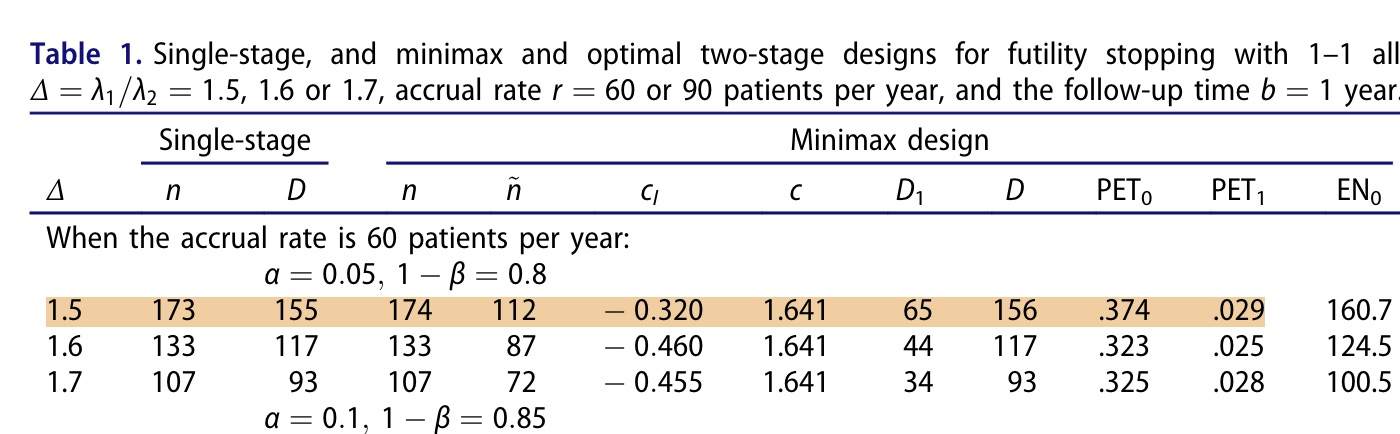

In [ ]:
display_jpeg(file='figures/Jung(2017)_table_1.jpeg')

#### Under PH, we can find a proper critical value to make 2 stages power ~ single stage 
#### This conclusion is true when stopping for both superiority and futility or for futility only.
#### overall $\textcolor{lightgreen}{\alpha = P(\frac{W_1}{\sigma_1}>C_u|H_0) + P(C_l<\frac{W_1}{\sigma_1}<C_u,\frac{W}{\sigma}>C|H_0)}$
-------

# Our Rejection Region
### <span style="color:yellow">E and C are the RMST value of experiment group and control group respectively
### subscript 1 means interim period, 2 for final period
#### Stage I : process to stage II (reject $H_0$) when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$, where $m_1>0$
### Stage II:
#### reject $H_0$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2},\ $  $m_1, m_2 >0$


### By the asymptotic normality of RMST:
$$
 \textcolor{lightgreen}{[E1-C1,\ E1,\ E2-C2,\ E2] \sim \mathcal{N}\ (\ \hat{\mu},\ \hat{\Sigma}\ )}
$$

$$
\hat{\Sigma} = 
 \left[
 \begin{matrix}
   Var(E1)+Var(C1) & Var(E1) & Cov(E1,E2)+Cov(C1,C2) & Cov(E1,E2) \\
                   & Var(E1) & Cov(E1,E2) & Cov(E1,E2) \\
                   &         & Var(E2)+Var(C2) & Var(E2)\\
                   &         &                 & Var(E2)\\
  \end{matrix}
\right]
$$

## Monte Carlo
$ var[\widehat{RMST_{E1}}]=\frac{1}{B}\sum\limits_{i = 1}^{B} (\widehat{RMST_{E1,i}} - \bar{RMST_{E1}})^2$

Similar to Lu(2021) 

$$
 \left[
 \begin{matrix}
   Var(\hat{E1}) & Cov(\hat{E1}, \hat{E2}) \\
   Cov(\hat{E1}, \hat{E2}) & Var{\hat{E2}} \\
  \end{matrix}
  \right] = 

\frac{1}{B}\sum\limits_{i = 1}^{B} 
 \left[
 \begin{matrix}
   \widehat{RMST_{E1}} - \bar{RMST_{E1}} \\
   \widehat{RMST_{E2}} - \bar{RMST_{E2}} \\
  \end{matrix}
  \right] ^{\bigotimes2}_i 
$$

$ \bar{RMST_{E1}} = \frac{1}{B}\sum^{B}_{i = 1}RMST_{E1,i}$ is the mean RMST value of simulation
#### <span style="color:yellow">Use the setting of Jung 2017 table 1 first row (Minimax)




In [12]:
set.seed(2024)
sim_size <- 10000 
N <- 200
r <- 100
acc_time <- N / r
cen_time <- 1
lambda_H0 <- 1.2
HR <- 0.7
lambda_H1 <- 1.2 * HR
change_time <- 1
interim <- 1.4
n <- ceiling(N / 2)
alpha <- 0.05

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
                                
rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)                                 
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

# log-rank data
lr_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h0_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
# Get W/sigma
z_stats_h1_int <- lr_h1_int$z_stats
z_stats_h1_fin <- lr_h1_fin$z_stats
z_stats_h0_int <- lr_h0_int$z_stats
z_stats_h0_fin <- lr_h0_fin$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin) 
# corr(W1, W | H0)
corr_h0 <- sqrt(mean(lr_h0_int$var_w) / mean(lr_h0_fin$var_w))         


#### The mean and cov estimation shown above are packed in function 'mu_cov_mc'
#### The Estimation of $\mu\ and\ \Sigma | H_0,\ H_1$ are shown above 

------

# <span style="color:yellow">  Parameter Optimization (Grid Search)
Reference: Zhou(2017) BOP2 Bayesian design. DOI:10.1002/sim.7338

#### In order to solve the critical values ($m_1,\ t_1,\ m_2,\ t_2$), a function that can control the normal probability is required. The following $\mathcal{f}(n)$  is what we proposed.
$$
\Large \mathcal{f}(n) = \mathcal{e}^{-\ \gamma · \frac{n}{N}}
$$
#### $n$ is the sample size(2 arms) of interim period. $N$ is the final total sample size of 2 arms. 
#### Then we set the following constraints:
$$
\begin{aligned}
\large P(E_1 - C_1 > m_1) &= \mathcal{f}(n)  \\
\large P(E_1 - C_1 > m_1\ \&\ E_1 > t_1) &= \lambda · \mathcal{f}(n) \\
\large P(E_2 - C_2 > m_2) &=  \mathcal{f}(N) \\
\large P(E_2 - C_2 > m_2\ \&\ E_2 > t_2) &= \lambda · \mathcal{f}(N) \\
0<\lambda<1,\ \gamma>0
\end{aligned}
$$

#### $ \mathcal{f}(n)$ is a monotonously decereasing funciton of n, which means that two probability constraints in interim period will go up when the interim sample size n decrease. <span style="color:yellow"> It leads to a small early stop probability with an insufficient interim sample size.  
#### Then we grid search $(\lambda, \gamma)$ . Each pair of $(\lambda, \gamma)$ determines a set of ($m_1,\ t_1,\ m_2,\ t_2$) by normal calculation. Record critical values sets that yield the desirable overall type I error $\alpha$:
$$
\large P(E_1-C_1>m_1\ \&\  E_1>t_1\ \&\  E_2 - C_2>m_2\ \&\  E_2>t_2\ |H_0) < \alpha
$$
#### Find the most powerful one under $H_1$ among these ($m_1,\ t_1,\ m_2,\ t_2$)

#### <span style="color:yellow"> Remark: for single stage design, we only search under the last two constraints.
#### * The grid searching procedure above is packed in function: 'adp_grid_src'

In [17]:
set.seed(2024)
best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
best_our

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.1112603,0.6678363,-0.01364468,0.9134872,0.95,0.01,0.6213,0.0532,0.0458,0.9065


### Use the normality of 4d RMST to calculate the Type I error and Power
### * The alpha and power calculated in the function above is based on the simulated survival data

In [18]:
threshold <- as.numeric(best_our[1:4])
# Monte Carlo normal probability 
norm_sam_h0 <- mvrnorm(100000, mu = mu_cov_h0$mu, Sigma = mu_cov_h0$sigma)
norm_sam_h1 <- mvrnorm(100000, mu = mu_cov_h1$mu, Sigma = mu_cov_h1$sigma)

cat('The type one error is:',sum(apply(norm_sam_h0, 1, function(x) all(x > threshold))) / 100000, '\n')
cat('The Power is:',sum(apply(norm_sam_h1, 1, function(x) all(x > threshold))) / 100000, '\n')

The type one error is: 0.04516 
The Power is: 0.89913 


### <span style="color:yellow">  The power is slightly higher than LR but cost should be global robustness (Litwin 2017)  
------


## Global Robustness
#### Litwin mentioned that when the real distribution parameters vary from the stated ones, the alpha under the same critical values will increase sharply. This method will sacrify globally robustness.
### <span style="color:yellow"> Compare the robustness between LR test and Our method when Hazard Ratio change
#### $\lambda_E| H_1 = 0.9,\ \frac{\lambda_E}{\lambda_C} = 0.67$ Follow Jung 2017 table1

In [19]:
best_lr <- find_m_logrank(logrank_data = logrank_data, search_times = 500, corr_h0 = corr_h0,
                 alpha = alpha, sim_size = sim_size)
best_rmst <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = alpha, sim_size = sim_size, method = 'Simple')
best_lr
best_rmst

m1,m2,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.6779285,1.641859,0.255,0.0188,0.0476,0.7407


m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02468095,0,0.1613846,0,0.01,0.22,0.6076,0.1265,0.0498,0.7566


### Mimic the situation that $\lambda_1$ is precise but real $\lambda_0$ deviates from the stated one
#### <span style="color:yellow"> Use the same critical values calculated when $\lambda_0 = 1.2, \lambda_1 = 0.84$
#### $H0: \lambda_E = \lambda_C = \lambda_0$
#### $H1: \lambda_C =  \lambda_0,\ \lambda_E =  \lambda_1$

In [35]:
m1 <- as.numeric(best_our[1])
t1 <- as.numeric(best_our[2])
m2 <- as.numeric(best_our[3])
t2 <- as.numeric(best_our[4])

# Critical value of LR and simple RMST
m1_lr <- best_lr$m1
m2_lr <- best_lr$m2
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

#lambda_H0 <- 1.2
lambda_H1 <- 1.2 * 0.7  #0.84
diff_HR_robust <- foreach(lambda_H0 = seq(0.8, 1.6, by = 0.05), .combine = rbind) %dopar%
{
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

    rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

    z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats

    a_lr <- sum(z_stats_h0_int > m1_lr & z_stats_h0_fin > m2_lr) / sim_size
    power_lr <- sum(z_stats_h1_int > m1_lr & z_stats_h1_fin > m2_lr) / sim_size
    pet0_lr <- sum(z_stats_h0_int <= m1_lr) / sim_size
    pet1_lr <- sum(z_stats_h1_int <= m1_lr) / sim_size

    a_rmst <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1_rmst) &
                    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2_rmst)) / sim_size
    power_rmst <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1_rmst) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2_rmst)) / sim_size
    pet0_rmst <- sum(rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1_rmst) / sim_size
    pet1_rmst <- sum(rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1_rmst) / sim_size

    a_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > t1) &
                (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > t2)) / sim_size
    power_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > t1) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > t2)) / sim_size
    pet0_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1) | (rmst_h0_int[2, ] <= t1)) / sim_size
    pet1_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1) | (rmst_h1_int[2, ] <= t1)) / sim_size
   
    return(c(lambda_H0, a_lr, a_rmst, a_our, power_lr, power_rmst, power_our, 
            pet0_lr, pet0_rmst, pet0_our, pet1_lr, pet1_rmst, pet1_our ))
}

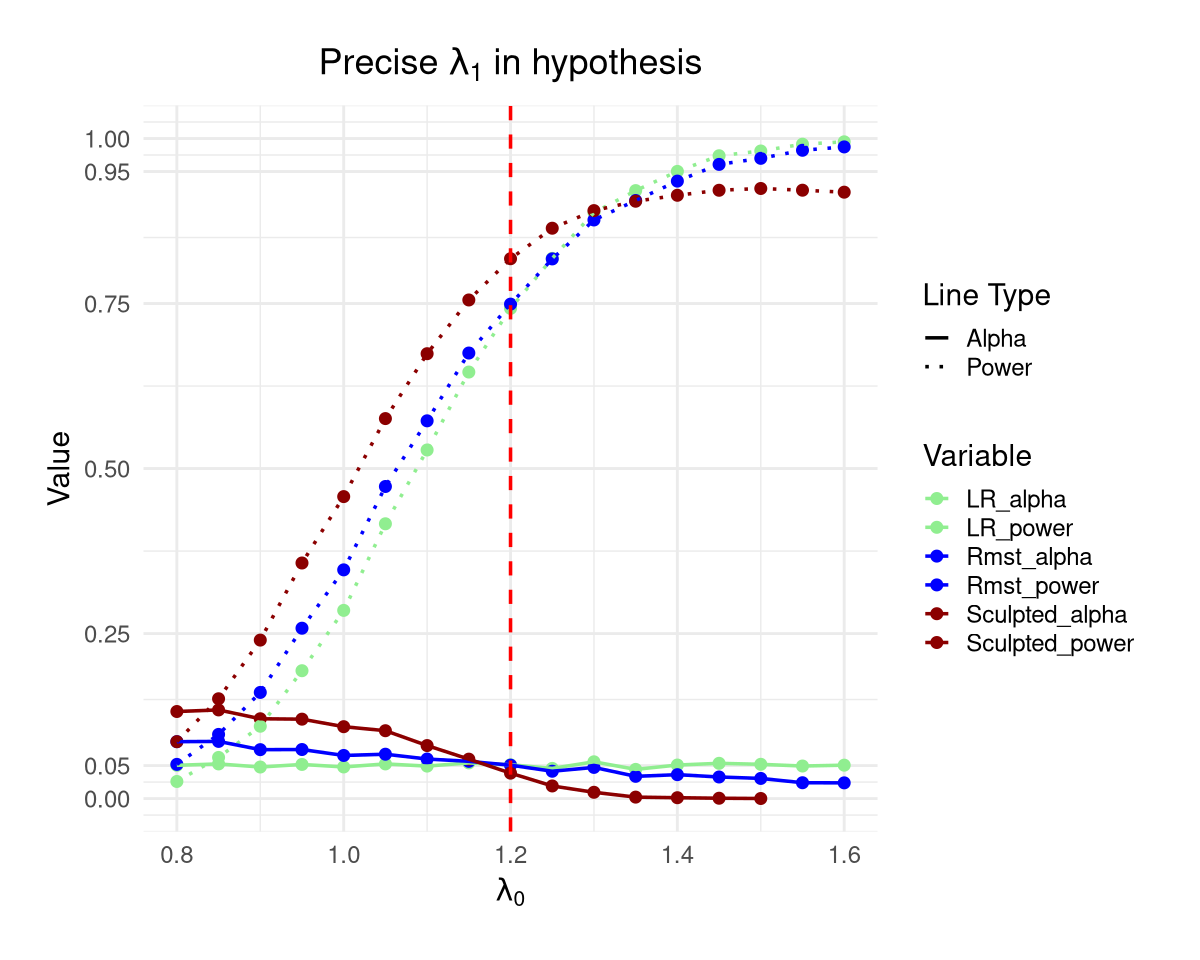

In [29]:
options(repr.plot.width = 10, repr.plot.height = 8)
data <- diff_HR_robust
    color_palette <- c("Sculpted_power" = "darkred", "Sculpted_alpha" = "darkred", 
                      "LR_power" = "lightgreen", "LR_alpha" = "lightgreen",
                      "Rmst_power" = "blue", "Rmst_alpha" = "blue",
                      "Sculpted_PET0" = "darkred", "Sculpted_PET1" = "darkred", 
                      "LR_PET0" = "lightgreen", "LR_PET1" = "lightgreen",
                      "Rmst_PET0" = "blue", "Rmst_PET1" = "blue")

    a_power_delta <- data.frame(data[, c(1,2,3,4,5,6,7)])
    colnames(a_power_delta) <- c('lambda_1','LR_alpha','Rmst_alpha','Sculpted_alpha',
                          'LR_power', 'Rmst_power','Sculpted_power')
    a_power_long <- a_power_delta %>%
        pivot_longer(cols = -!!sym('lambda_1'), names_to = "variable", values_to = "value")%>%
        mutate(linetype_group = ifelse(variable %in% 
            c("LR_alpha", "Rmst_alpha", "Sculpted_alpha"), "Alpha", "Power"))
    a_power_long <- a_power_long %>% filter(value != 0)   # 0 means could not find critical values

p_HR1 <- ggplot(a_power_long, aes(x = !!sym('lambda_1'), y = value, 
        color = variable, linetype = linetype_group)) +
    geom_point(size = 3) +
    geom_line(linewidth = 1) +
    geom_vline(xintercept = 1.2, color = "red", linetype = "dashed", linewidth = 1) +
    scale_linetype_manual(values = c("Alpha" = "solid", "Power" = "dotted")) +
    labs( linetype = "Line Type", color = "Variable",
          title = "Line Plot with Different Line Types") +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 0.95, 1), limits = c(0, 1)) +
    scale_color_manual(values = color_palette) +
    labs(x = expression(lambda[0]), y = "Value", color = "Variable",
      title = expression(paste("Precise ",lambda[1]," in hypothesis"))) +
    theme_minimal(base_size = 18) + 
    theme(plot.title = element_text(hjust = 0.5),
          plot.background = element_rect(fill = "white", color = NA),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    guides(linetype = guide_legend(override.aes = list(color = "black")),
        color = guide_legend(override.aes = list(linetype = "solid")))
p_HR1
#ggsave("Early_diff_robust.pdf", plot = p_HR, width = 10, height = 7, limitsize = FALSE)

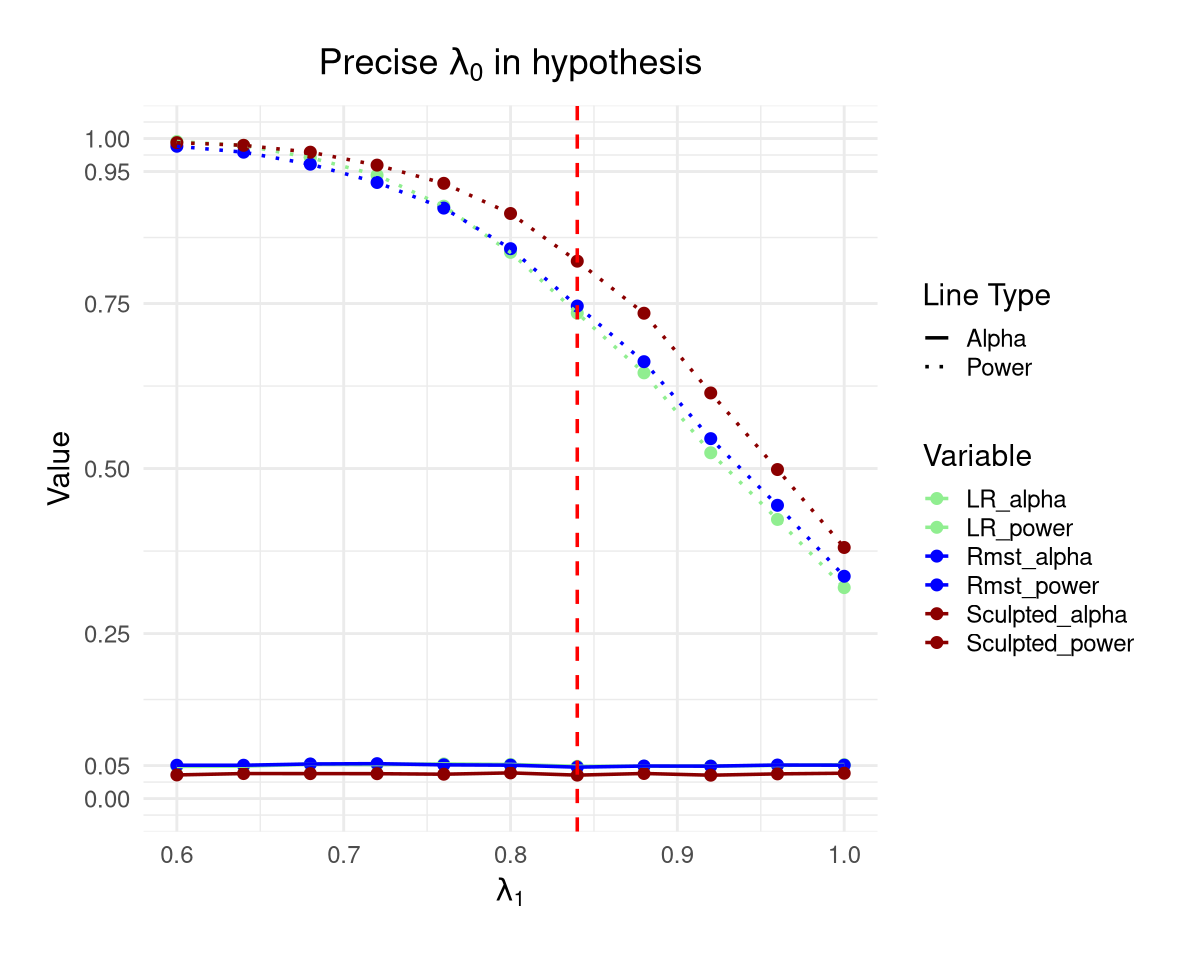

In [30]:
p_HR2

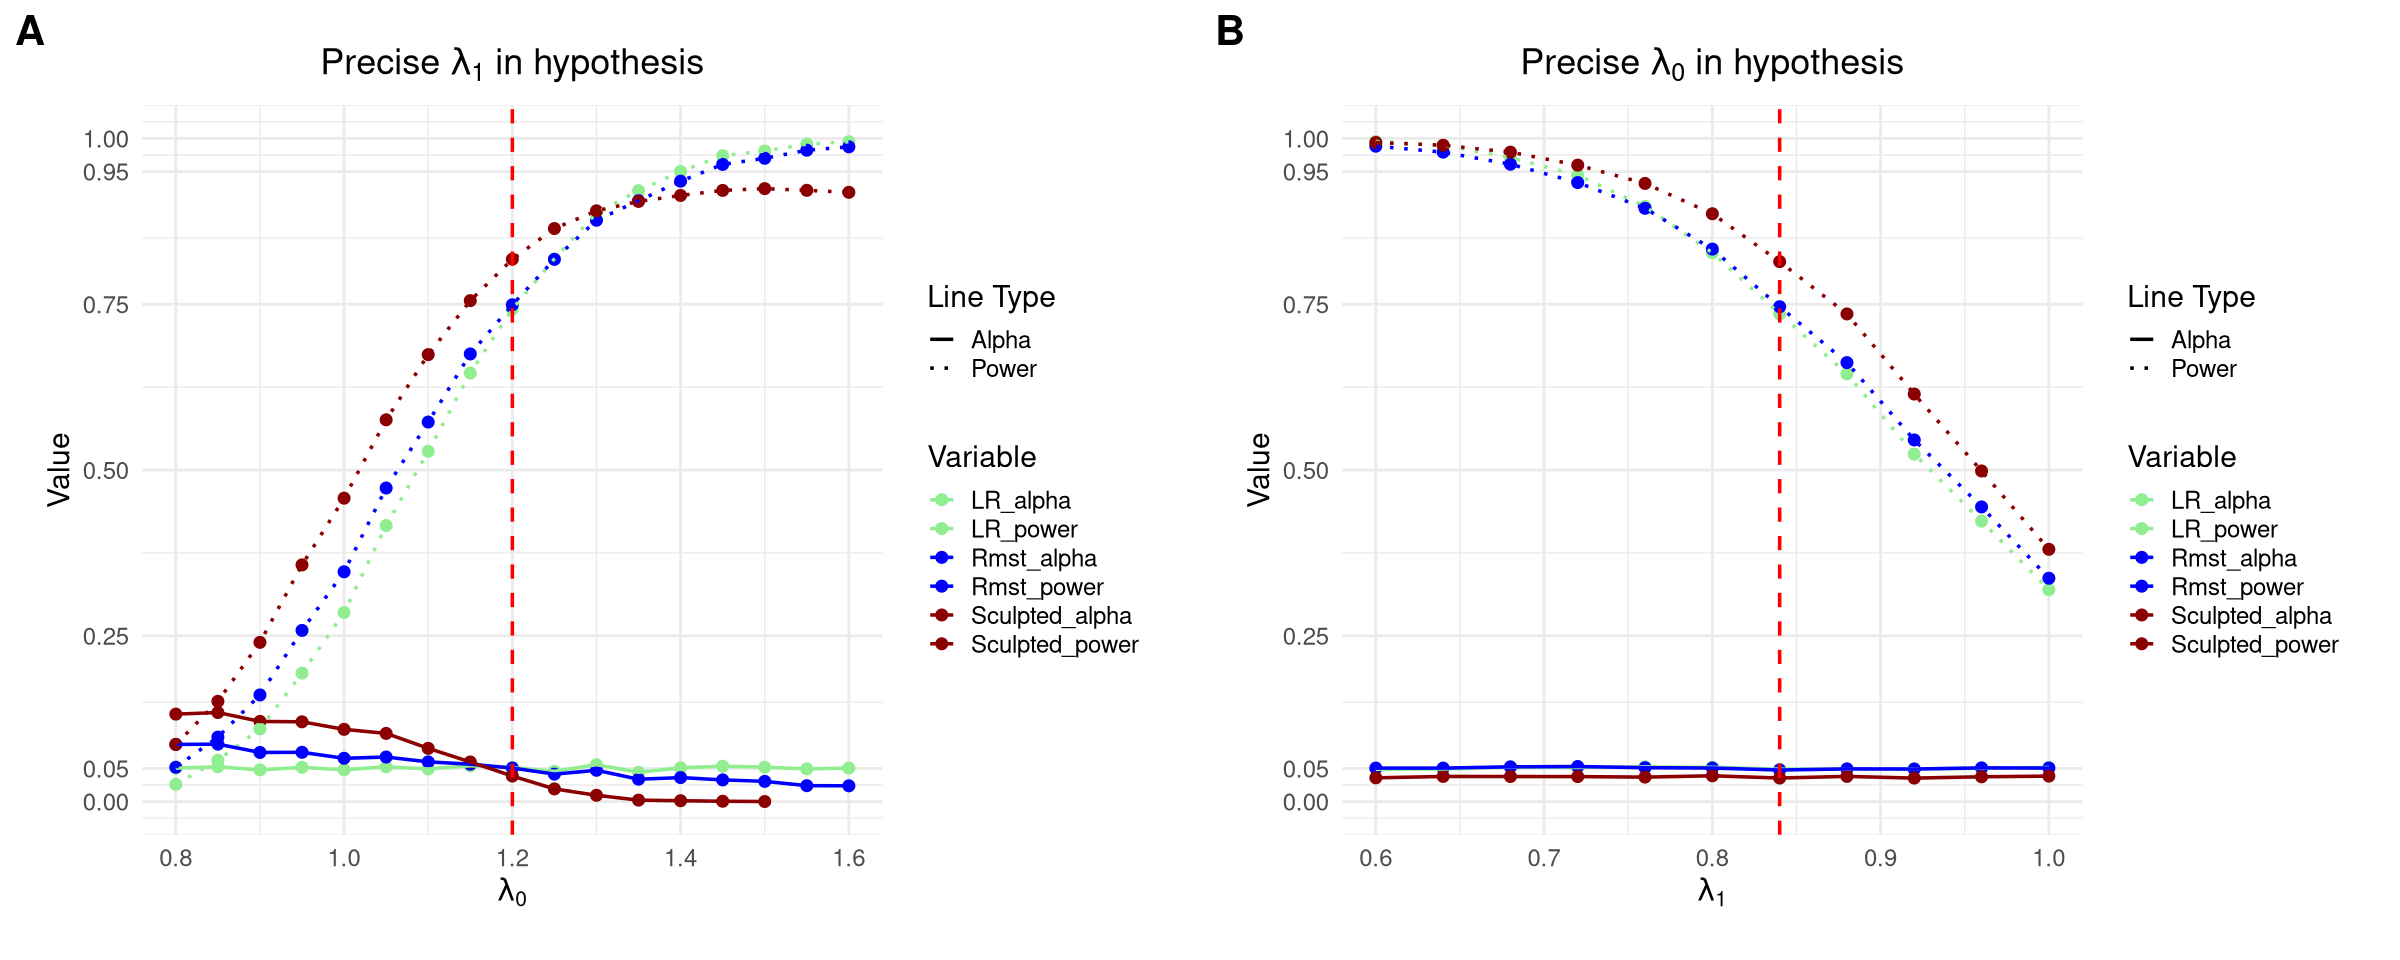

In [33]:
options(repr.plot.width = 20, repr.plot.height = 8)
combined_plot <- plot_grid(p_HR1, p_HR2, labels = c("A", "B"), label_size = 25, ncol = 2)
ggsave("figures/Robustness.pdf", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

-------

## Visualization of critical regions

In [21]:
m1 <- as.numeric(best_our[1])
t1 <- as.numeric(best_our[2])
m2 <- as.numeric(best_our[3])
t2 <- as.numeric(best_our[4])
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

best_our
best_rmst

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.1112603,0.6678363,-0.01364468,0.9134872,0.95,0.01,0.6213,0.0532,0.0458,0.9065


m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02468095,0,0.1613846,0,0.01,0.22,0.6076,0.1265,0.0498,0.7566


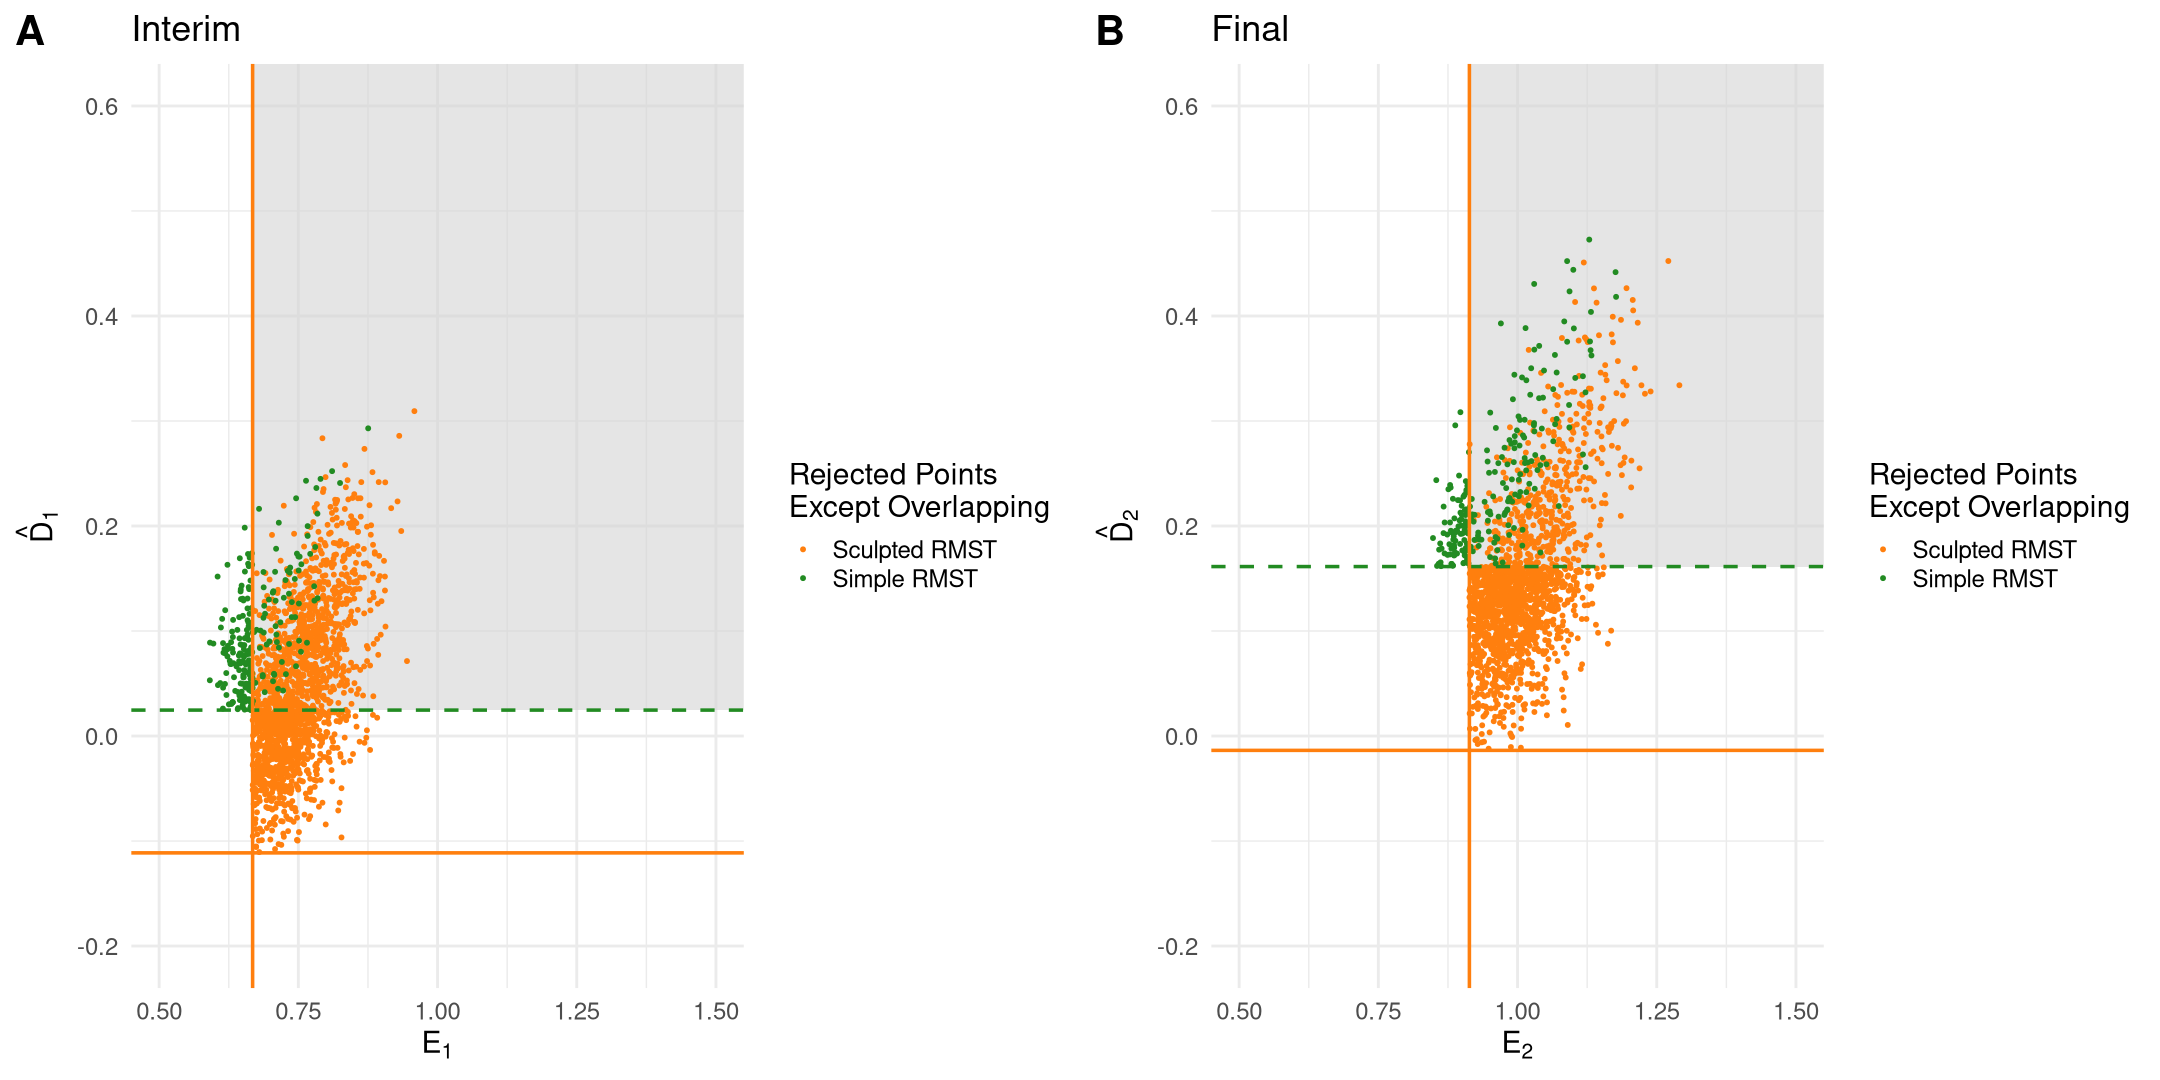

In [45]:
rmst_data <- rbind(rmst_h1_int, rmst_h1_fin)
D1 <- rmst_data[2,] - rmst_data[1,]
R1 <- rmst_data[2,]
D2 <- rmst_data[4,] - rmst_data[3,]
R2 <- rmst_data[4,]
# Rejection region
Scu_R <- as.matrix(rmst_data[, which(D1 > m1 & R1 > t1 & D2 > m2 & R2 > t2)])
Sim_R <- as.matrix(rmst_data[, which(D1 > m1_rmst & D2 > m2_rmst)])

# Prepare data for the first scatterplot
data1 <- data.frame(
  x = c(Scu_R[2, ], Sim_R[2, ]),
  y = c(Scu_R[2, ] - Scu_R[1, ], Sim_R[2, ] - Sim_R[1, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data1 <- data1 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

data1 <- data1[data1$overlap != 'Overlap' , ]
plot1 <- ggplot(data1, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = t1, xmax = Inf, ymin = m1_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e")) +
  labs(title = "Interim", 
      x = expression(E[1]), 
      y = expression(hat(D)[1]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(0.5, 1.5) +
  ylim(-0.2, 0.6)+
  geom_hline(aes(yintercept = m1_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = t1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) 
  

# Prepare data for the second scatterplot
data2 <- data.frame(
  x = c(Scu_R[4, ], Sim_R[4, ]),
  y = c(Scu_R[4, ] - Scu_R[3, ], Sim_R[4, ] - Sim_R[3, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data2 <- data2 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

data2 <- data2[data2$overlap != 'Overlap' , ]
plot2 <- ggplot(data2, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = t2, xmax = Inf, ymin = m2_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e")) +
  labs(title = "Final", 
      x = expression(E[2]), 
      y = expression(hat(D)[2]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(0.5, 1.5) +
  ylim(-0.2, 0.6)+
  geom_hline(aes(yintercept = m2_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = t2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE)


options(repr.plot.width = 18, repr.plot.height = 9)
combined_plot <- plot_grid(plot1, plot2, labels = c("A", "B"), label_size = 25, ncol = 2)
ggsave("figures/rejection_plot.pdf", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

In [27]:
data1

x,y,group,overlap
<dbl>,<dbl>,<chr>,<chr>
0.6940300,0.103546028,Sculpted RMST,Overlap
0.7093327,0.148785738,Sculpted RMST,Overlap
0.7218492,0.218445199,Sculpted RMST,Overlap
0.6880813,0.129726544,Sculpted RMST,Overlap
0.7067243,0.069488740,Sculpted RMST,Overlap
0.8483933,0.122717908,Sculpted RMST,Overlap
0.8674512,0.208073887,Sculpted RMST,Overlap
0.7646166,0.062146046,Sculpted RMST,Overlap
0.7283276,0.112675331,Sculpted RMST,Overlap


### 245 green dots, 132 orange and 253 blue

In [110]:
# Blue dots outside of shaded region interim
dim(data1[data1$overlap != 'Overlap' & data1$group == 'Simple RMST' & data1$x<t1, ])
# orange dots outside of shaded region interim
dim(data1[data1$overlap != 'Overlap' & data1$group == 'Sculpted RMST' & data1$y<m1_rmst, ])

# Blue dots out of shaded region final
dim(data2[data2$overlap != 'Overlap' & data2$group == 'Simple RMST' & data2$x < t2, ])
# orange dots out of shaded region final
dim(data2[data2$overlap != 'Overlap' & data2$group == 'Sculpted RMST' & data2$y < m2_rmst, ])

[1] 55  4

[1] 22  4

[1] 240   4

[1] 121   4

####  Blue dots on the left lateral region of the shaded region increase by 240-55 = 185 from interm to final  
####  Orange dots below the shaded region increase by 121-22 = 99 from interm to final 
---- 

## Why type I error is lower than anticipated?

In [3]:
set.seed(2024)
sim_size <- 10000 
N <- 200
r <- 100
acc_time <- N / r
cen_time <- 1
lambda_H0 <- 1.2
HR <- 0.7
lambda_H1 <- 1.2 * HR
change_time <- 1
interim <- 1.4
n <- ceiling(N / 2)
alpha <- 0.05

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
                                
rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)                                 
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

In [4]:
rmst_data

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
Est.,0.5904840,0.6903969,0.5605469,0.5034040,0.5583547,0.6542325,0.7090195,0.6593774,0.6599138,0.6156522,⋯,0.6791940,0.6311094,0.6973790,0.5541534,0.5923308,0.7577937,0.7148658,0.7068968,0.5958085,0.6742074
Est.,0.7235067,0.5971577,0.6463712,0.7301894,0.7738569,0.6868050,0.6701880,0.6944500,0.5971973,0.7371792,⋯,0.6623293,0.6055309,0.7570422,0.5609683,0.6509337,0.6682533,0.5659556,0.6872657,0.7055522,0.6382564
Est.,0.5904840,0.6976015,0.5605469,0.5034040,0.5583547,0.6372355,0.7256754,0.6593774,0.7024705,0.6156522,⋯,0.6791940,0.6311094,0.6892069,0.5554921,0.5923308,0.7577937,0.6909024,0.7068968,0.5958085,0.6830157
Est.,0.6940300,0.6407827,0.7093327,0.7218492,0.6880813,0.7067243,0.8483933,0.8674512,0.7646166,0.7283276,⋯,0.8225290,0.8728353,0.7229659,0.8153730,0.7727680,0.8098856,0.6941525,0.9120476,0.7783004,0.6705579
Est.,0.8196167,0.8278775,0.6267604,0.5884765,0.7358074,0.7654841,0.8421469,0.7936093,0.8155353,0.7962928,⋯,0.8845452,0.7594797,0.7874972,0.6015142,0.6631985,0.8871566,0.8867310,0.8081697,0.7766163,0.7788718
Est.,0.8255212,0.7151416,0.8274682,0.9339504,0.8697748,0.7975732,0.7846772,0.8022655,0.7448579,0.9271776,⋯,0.8886983,0.7658896,0.7838990,0.7219734,0.8036507,0.8333240,0.9274001,0.8510580,0.6781392,0.6767298
Est.,0.8196167,0.8278775,0.6267604,0.5884765,0.7358074,0.7654841,0.8421469,0.7936093,0.8181078,0.7962928,⋯,0.8976292,0.7594797,0.7874972,0.6015142,0.6631985,0.8972126,0.8867310,0.8081697,0.7766163,0.7788718
Est.,0.9831082,0.9340206,0.9296583,1.0808536,1.0477299,1.0302970,1.0357090,1.0337579,1.1643194,1.0422756,⋯,1.0456568,1.1492003,0.7989664,0.9617288,1.0744264,1.1161312,0.9734155,1.2125110,0.9304583,1.0062246


In [10]:
    set.seed(2024)
    int_n <- interim * r
    fin_n <- 2 * n
      
      mu1 <- mu_cov_h1$mu[c(1,2)]
      sigma1 <- mu_cov_h1$sigma[1:2, 1:2]
      # Final
      mu2 <- mu_cov_h1$mu[c(3,4)]
      sigma2 <- mu_cov_h1$sigma[3:4, 3:4]

      # Function to minimize solve t in P(E-C > m & E > t) = tar_prob given m
      norm_2d <- function(t, m, mean, sigma, tar_prob) 
        {
          prob <- pmvnorm(lower = c(m, t), 
                          upper = rep(Inf, 2), 
                          mean = mean, 
                          sigma = sigma)
          return (prob - tar_prob)
        }

      rmst_h0_int <- rmst_data[c(1,2) , ]
      rmst_h1_int <- rmst_data[c(3,4) , ]
      rmst_h0_fin <- rmst_data[c(5,6) , ]
      rmst_h1_fin <- rmst_data[c(7,8) , ]
      #Grid search
    crit_val_res <- foreach(lambda = seq(0.01, 0.99, 0.02), .combine = 'cbind') %dopar%
      {   
        best_gamma <- c()
        best_power <- 0
        for (gamma in seq(0, 2, by = 0.02))
          {
            p1_tar <- exp(-gamma * (int_n / fin_n))             # P(E1-C1 > m1)
            p2_tar <- lambda * exp(-gamma * (int_n / fin_n))    # P(E1-C1 > m1, E1 > t1)
            p3_tar <- exp(-gamma * ( fin_n / fin_n))            # P(E2-C2 > m2)
            p4_tar <- lambda * exp(-gamma * (fin_n / fin_n))    # P(E2-C2 > m2, E2 > t2)

            # First equation P(E1-C1 > m1) = p1_tar
            m1 <- qnorm(1 - p1_tar, mean = mu1[1], sd = sqrt(sigma1[1, 1]))
            # Third equation
            m2 <- qnorm(1 - p3_tar, mean = mu2[1], sd = sqrt(sigma2[1, 1])) 

              # Second equation P(E1-C1 > m1 & E1 > t1) = p2_tar
              t1 <- uniroot(norm_2d, interval = c(0, 100), m = m1, 
                          mean = mu1, sigma = sigma1, tar_prob = p2_tar)$root
              # Forth equation
              t2 <- uniroot(norm_2d, interval = c(0, 100), m = m2, 
                        mean = mu2, sigma = sigma2, tar_prob = p4_tar)$root

            proc_h0 <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > t1) &
                      (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > t2))
            proc_h1 <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > t1) &
                      (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > t2))

              if ( m1 > 0 & m2 > 0 & proc_h0 / sim_size <= alpha 
                & proc_h1 / sim_size > best_power)  #control alpha, find the most powerful set
              {
                best_power <- proc_h1 / sim_size
                best_gamma <- c(m1, t1, m2, t2, lambda, gamma, proc_h0/sim_size, proc_h1/sim_size)
              }
            }
        best_gamma 
        }

        if (is.null(crit_val_res) ) 
          {   # Return NULL when something goes wrong
            return(data.frame(m1 = 0, t1 = 0, m2 = 0, t2 = 0, lambda = 0,
                        gamma = 0, PET0 = 0, PET1 = 0, alpha = 0, power = 0))
          }
        best_res <- crit_val_res[, which(crit_val_res[8, ] == max(crit_val_res[8, ]))]
        PET0 <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] < best_res[1]) | 
                  (rmst_h0_int[2, ] < best_res[2])) / sim_size
        PET1 <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] < best_res[1]) | 
                  (rmst_h1_int[2, ] < best_res[2])) / sim_size

data.frame(m1 = best_res[1], t1 = best_res[2], m2 = best_res[3],
                        t2 = best_res[4], lambda = best_res[5], gamma = best_res[6],
                        PET0 = PET0, PET1 = PET1, alpha = best_res[7], power = best_res[8])


m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.724655e-05,0.6461077,0.12908,0.8983987,0.99,0.14,0.626,0.0903,0.0377,0.8237


In [11]:
sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > 0) & (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > 0)) / sim_size

[1] 0.3557